In [205]:
import pyodbc
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
conn = pyodbc.connect(
    "DRIVER={SQL Server};"
    "SERVER=DESKTOP-9MQ1CAL;"
    "DATABASE=DW_FINANCE;"
    "Trusted_Connection=yes;"
)

# Vérification de la connexion
cursor = conn.cursor()
cursor.execute("SELECT @@VERSION;")
print(cursor.fetchone())  # Affiche la version de SQL Server

('Microsoft SQL Server 2012 - 11.0.2100.60 (Intel X86) \n\tFeb 10 2012 19:13:17 \n\tCopyright (c) Microsoft Corporation\n\tBusiness Intelligence Edition on Windows NT 6.2 <X64> (Build 9200: ) (WOW64) (Hypervisor)\n',)


In [207]:
query_tables = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'"
df_tables = pd.read_sql(query_tables, conn)
print(df_tables)


                TABLE_NAME
0              Fact_Supply
1                  Dim_Geo
2       Fact_ReviewProduct
3               Fact_Sales
4             Dim_Category
5                Dim_Date_
6             Dim_Product1
7              Dim_Company
8             Dim_Disputes
9            Dim_Suppliers
10            Dim_Customer
11        Dim_Transaction1
12               Dim_Store
13       dim_ReviewProduct
14              Dim_Review
15           Dim_Promotion
16             Dim_Invoice
17  Dim_FinancialStatement
18      Dim_AccountJournal
19             Dim_Account
20            Fact_Finance
21             sysdiagrams
22                DIM_Date
23            dim_Invoices
24             Fact_Review


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_37984\1062794786.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tables = pd.read_sql(query_tables, conn)


In [209]:
# Extraire uniquement les noms sous forme de liste
tables = df_tables["TABLE_NAME"].tolist()

# Boucle pour afficher les colonnes de chaque table
for table in tables:
    print(f"\n🔸 Table: {table}")
    query_columns = f"""
    SELECT COLUMN_NAME, DATA_TYPE
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE TABLE_NAME = '{table}'
    """
    columns = pd.read_sql(query_columns, conn)
    print(columns.to_string(index=False))



🔸 Table: Fact_Supply
    COLUMN_NAME DATA_TYPE
      InvoiceID       int
     SupplierID       int
      PaymentID   varchar
      DisputeFK       int
    DisputeDate       int
 ResolutionDate       int
    InvoiceDate       int
        DueDate       int
 PaymentDueDate       int
    PaymentDate       int
         Amount   decimal
DiscountOffered   decimal
   DiscountUsed   decimal
         IsLate       int
        IsError       int
   ReminderDate      date

🔸 Table: Dim_Geo
  COLUMN_NAME DATA_TYPE
TransactionPK       int
TransactionID   varchar
         Type   varchar

🔸 Table: Fact_ReviewProduct
COLUMN_NAME DATA_TYPE
ProductIDFK       int
ReviewScore   varchar
ReviewCount   varchar
      Price   varchar
   Category       int

🔸 Table: Fact_Sales
  COLUMN_NAME DATA_TYPE
TransactionFK       int
      StoreFK       int
    ProductFK       int
   CustomerFK       int
       Amount   decimal
PaymentMethod   varchar
       DatePK       int
  Description   varchar

🔸 Table: Dim_Category
 

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_37984\479596255.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns = pd.read_sql(query_columns, conn)
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_37984\479596255.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns = pd.read_sql(query_columns, conn)
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_37984\479596255.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  columns = pd.read_sql(query_columns, conn)
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_37984

In [212]:
query = """
SELECT DISTINCT year
FROM Fact_Finance
ORDER BY year;
"""

annees = pd.read_sql(query, conn)
print("✅ Années disponibles dans Fact_Finance :")
print(annees)


✅ Années disponibles dans Fact_Finance :
   year
0  2015
1  2016
2  2017
3  2018
4  2019
5  2020
6  2021
7  2022
8  2023
9  2024


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_37984\2757403347.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  annees = pd.read_sql(query, conn)


In [214]:
query = """
WITH RankedFinance AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY year ORDER BY NEWID()) AS rn
    FROM Fact_Finance
)
SELECT *
FROM RankedFinance
WHERE rn = 1
ORDER BY year;
"""

df_10_years = pd.read_sql(query, conn)
df_10_years.head(10)


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_37984\4160244464.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_10_years = pd.read_sql(query, conn)


,StatementIDFK,year,Valeur_des_Actifs,Amortissement_Cumulé,Coût_de_Maintenance,Revenu,Investissement_dans_les_Actifs,TotalAssets,TotalLiabilities,Equity,Budget,ActualExpenses,GrandLivreIDFK,rn
0,9669,2015,249380656,7.980181e+07,8044493,6095249680,1.985256e+08,547858.20,296204.77,251653.43,479379.17,17499.10,GL10080,1
1,8224,2016,321738870,1.093912e+08,7162957,6893957500,2.138297e+08,413353.99,152152.39,261201.60,393497.97,23582.48,GL10080,1
2,7328,2017,372642122,1.341512e+08,13387523,6418321084,2.310277e+08,846098.16,22555.32,823542.84,116360.40,96819.52,GL10080,1
3,9481,2018,281044025,1.067967e+08,5706196,7339604054,2.871201e+08,800612.44,177629.49,622982.95,206681.71,33503.54,GL10080,1
4,3751,2019,331762460,1.327050e+08,8782928,6008379780,2.944970e+08,412740.00,55932.00,356808.00,10973.00,6487.00,GL02216,1
5,6036,2020,204497822,8.588909e+07,5283669,6143543089,2.443343e+08,461729.00,64092.00,397637.00,42987.00,15683.00,GL02652,1
6,5052,2021,398083886,1.751569e+08,6805555,6410099608,2.163652e+08,265287.00,93148.00,172139.00,39337.00,8582.00,GL03383,1
7,5892,2022,277206699,1.275151e+08,8017654,7757450828,2.439506e+08,199476.00,20499.00,178977.00,29745.00,14457.00,GL00315,1
8,75,2023,330063920,1.584307e+08,5774228,6028045600,1.987448e+08,445088.00,57987.00,387101.00,47921.00,19662.00,GL03282,1
9,3878,2024,431910350,2.159552e+08,7552844,7979323400,3.189714e+08,488049.00,32033.00,456016.00,24001.00,18046.00,GL03317,1


In [216]:
df = df_10_years.drop(columns=["rn"])


In [218]:
# 🔁 Ajout de bruit (données augmentées à partir de df original)
np.random.seed(42)
df_list = []

for _ in range(20):  # 🔁 Générer 20 copies bruitées
    copie = df.copy()
    for col in copie.select_dtypes(include=[np.number]).columns:
        if col not in ["year"]:  # on ne bruit pas "year"
            bruit = np.random.normal(0, 0.05, size=len(copie))  # ±5% de bruit
            copie[col] = copie[col] * (1 + bruit)
    df_list.append(copie)

df_aug = pd.concat(df_list, ignore_index=True)

In [220]:
# 🎯 Préparation des données
X = df_aug.drop(columns=["Revenu", "GrandLivreIDFK", "StatementIDFK"])
y = df_aug["Revenu"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [222]:
# 🌲 Modèle Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [224]:
# 🚀 Modèle XGBoost
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [226]:
# 📊 Résultats
print("✅ Résultats Random Forest")
print("R² :", round(r2_score(y_test, rf_pred), 4))
print("MSE :", round(mean_squared_error(y_test, rf_pred), 2))

✅ Résultats Random Forest
R² : 0.6634
MSE : 1.95931150925448e+17


In [228]:
print("\n✅ Résultats XGBoost")
print("R² :", round(r2_score(y_test, xgb_pred), 4))
print("MSE :", round(mean_squared_error(y_test, xgb_pred), 2))


✅ Résultats XGBoost
R² : 0.5869
MSE : 2.4043670984458026e+17


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_37984\2750534594.py:10: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


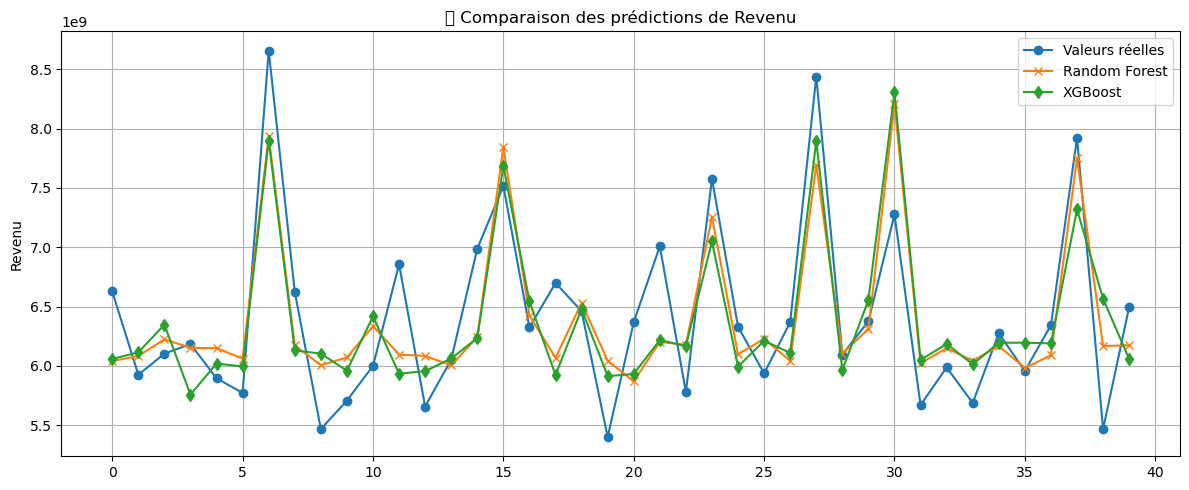

In [230]:
# 📈 Visualisation des performances
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Valeurs réelles", marker="o")
plt.plot(rf_pred, label="Random Forest", marker="x")
plt.plot(xgb_pred, label="XGBoost", marker="d")
plt.title("📈 Comparaison des prédictions de Revenu")
plt.ylabel("Revenu")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_37984\821870879.py:4: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from current font.
  plt.tight_layout()
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


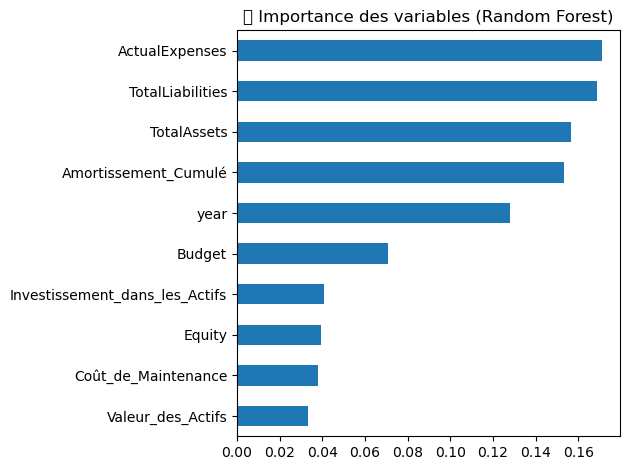

In [232]:
# 🔍 Importance des variables (Random Forest)
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(
    kind="barh", title="🌲 Importance des variables (Random Forest)")
plt.tight_layout()
plt.show()

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_37984\563043164.py:4: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  plt.tight_layout()
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


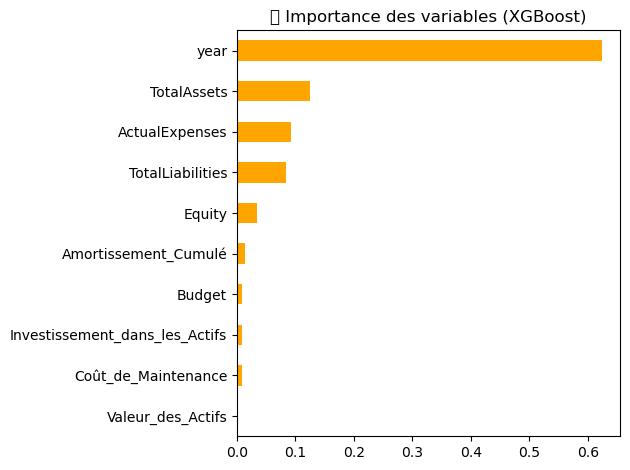

In [234]:
# 🔍 Importance des variables (XGBoost)
pd.Series(xgb.feature_importances_, index=X.columns).sort_values().plot(
    kind="barh", title="🚀 Importance des variables (XGBoost)", color="orange")
plt.tight_layout()
plt.show()

In [236]:
results = pd.DataFrame({
    "Modèle": ["Random Forest", "XGBoost"],
    "R² Score": [r2_score(y_test, rf_pred), r2_score(y_test, xgb_pred)],
    "MSE": [mean_squared_error(y_test, rf_pred), mean_squared_error(y_test, xgb_pred)]
})

print("📊 Résumé des performances :")
display(results)


📊 Résumé des performances :


,Modèle,R² Score,MSE
0,Random Forest,0.663352,1.959312e+17
1,XGBoost,0.586883,2.404367e+17


In [238]:
# ⚖️ Calcul des valeurs moyennes (pour simuler l'année 2025)
valeurs_moyennes = X.mean().to_frame().T

# 📈 Prédiction
prediction_2025_rf = rf.predict(valeurs_moyennes)[0]

# 💬 Affichage
print("📈 Revenu estimé pour l'année 2025 (Random Forest) :", round(prediction_2025_rf))


📈 Revenu estimé pour l'année 2025 (Random Forest) : 6714735710


In [240]:
valeurs_moyennes["year"] = 2025  # On ajoute l'année à la ligne moyenne
revenu_2025 = rf.predict(valeurs_moyennes)[0]
valeurs_moyennes["Revenu_Prédit"] = revenu_2025

display(valeurs_moyennes)


,year,Valeur_des_Actifs,Amortissement_Cumulé,Coût_de_Maintenance,Investissement_dans_les_Actifs,TotalAssets,TotalLiabilities,Equity,Budget,ActualExpenses,Revenu_Prédit
0,2025,3.199580e+08,1.328411e+08,7.640102e+06,2.453011e+08,488757.182729,97250.334738,390675.321561,140546.430409,25474.156028,7.160427e+09


In [250]:
try:
    cursor.execute("""
        ALTER TABLE Fact_Finance
        ADD RevenuPrévu_NextYear FLOAT;
    """)
    print("✅ Colonne 'RevenuPrévu_NextYear' ajoutée.")
except Exception as e:
    print("⚠️ Erreur lors de l'ajout de la nouvelle colonne :", e)

conn.commit()

✅ Colonne 'RevenuPrévu_NextYear' ajoutée.


In [253]:
# Reprendre les colonnes originales utilisées à l'entraînement
colonnes_features = X.columns  # Très important

# Liste des années à mettre à jour
annees_existantes = list(range(2015, 2025))  # Tu m’as dit de 2015 à 2024

predictions = {}

for annee in annees_existantes:
    # Recrée une ligne identique à la structure de X
    ligne = pd.DataFrame([X.drop(columns=["year"]).mean()])
    ligne["year"] = annee + 1

    # Réordonner les colonnes pour matcher le modèle
    ligne = ligne[colonnes_features]

    # Prédire le revenu
    RevenuPrévu_NextYear = rf.predict(ligne)[0]
    predictions[annee] = round(RevenuPrévu_NextYear, 2)


In [255]:
cursor = conn.cursor()

for annee, revenu in predictions.items():
    cursor.execute("""
        UPDATE Fact_Finance
        SET RevenuPrévu_NextYear = ?
        WHERE year = ?
    """, revenu, annee)

conn.commit()
cursor.close()

print("✅ Mise à jour de la colonne RevenuPrévu_NextYear terminée.")


✅ Mise à jour de la colonne RevenuPrévu_NextYear terminée.
